# Введение в искусственные нейронные сети
# Домашняя работа 4. Сверточные нейронные сети

### Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.

In [42]:
import tensorflow.keras as keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model 

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# установка параметров нейросети
num_classes = 10

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


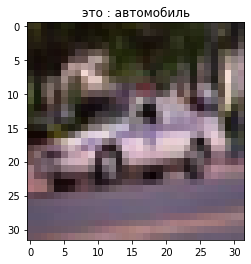

In [4]:
N = 193

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

Построим модель со случайными параметрами.

In [144]:
first_input = Input(shape=(32,32,3))
x11 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(first_input)
x11_pool = MaxPooling2D(pool_size=(2, 2))(x11)
x11_pool_drop = Dropout(0.25)(x11_pool)
first_dense = x11_pool_drop

x22= Conv2D(32, (3, 3), activation='relu', padding = 'same')(first_input)
x22_pool = MaxPooling2D(pool_size=(2, 2))(x22)
x22_pool_drop = Dropout(0.25)(x22_pool)
second_dense = x22_pool_drop

merge_one = Concatenate(axis =-1)([first_dense, second_dense])

x33= Conv2D(64, (3, 3), activation='relu', padding = 'same')(first_input)
x33_pool = MaxPooling2D(pool_size=(2, 2))(x33)
x33_pool_drop = Dropout(0.25)(x33_pool)
merge_two1 = Concatenate(axis = -1)([merge_one, x33_pool_drop])
merge_two = Flatten()(merge_two1)
dense1 = Dense(128, activation='relu')(merge_two)
dense1_drop = Dropout(0.5)(dense1)
dense2 = Dense(10, activation='softmax')(dense1_drop)

model_stek = Model(inputs=first_input, outputs=dense2)
ada_grad = keras.optimizers.Adagrad(learning_rate=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

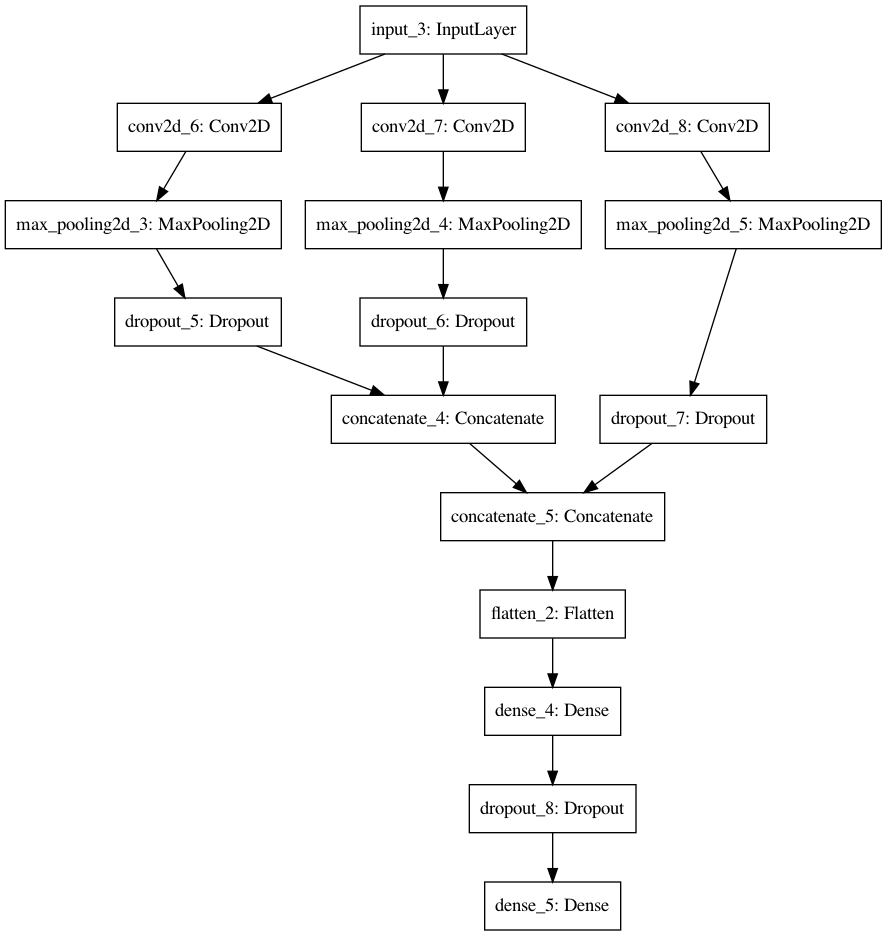

In [33]:
plot_model(model_stek,'model_stek.png')

In [6]:
model_stek.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [145]:
history = model_stek.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
1563/1563 [==============================] - 145s 93ms/step - loss: 1.7518 - accuracy: 0.3619 - val_loss: 1.3710 - val_accuracy: 0.5035
Epoch 2/2
1563/1563 [==============================] - 137s 88ms/step - loss: 1.4208 - accuracy: 0.4896 - val_loss: 1.2271 - val_accuracy: 0.5645


Точность на тесте для построенной сети составила 0.5645 - довольно неплохо.

### Подбор параметров:
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)

Для подбора параметров приняты следующие допущения:
1. Изменение числа нитей реализовано как Concatenate() для сверточных Conv2D слоев, равных заданному числу нитей.
2. Изменение числа слоев реализовано путем добавления дополнительных полносвязных Dense слоев после объединенного слоя Concatenate().
3. Число ядер меняется для Conv2D слоев.
4. Дополнительно производится подбор размера фильтра (3, 3) и (4, 4).
5. Для увеличения скорости обучения установлен batch_size=128 и число эпох установлено на 2, что могло бы несколько снизить общее качество обучения (модели не успевают доучиться). Data augmentation не применяется.
6. Обучение с каждым набором параметров запускается лишь раз (усреднение метрик не используется), чтобы сэкономить время подбора.

In [40]:
parameters = {'n_kernels': [32, 64], 
              'n_layers': [2, 4], 
              'n_threads': [2, 4],
              'kernel_size': [(3, 3), (4, 4)]}

In [41]:
%%time
results = []
for temp_params in product(*parameters.values()):
    temp_parameters = {'n_kernels': temp_params[0],
                       'n_layers': temp_params[1],
                       'n_threads': temp_params[2],
                       'kernel_size': temp_params[3],
                       'accuracy_test': 0}

    first_input = Input(shape=(32,32,3))
    for i in range(temp_parameters['n_layers'] - 1):
        merged = Concatenate(axis =-1)([Conv2D(temp_parameters['n_kernels'], 
                                       temp_parameters['kernel_size'],
                                       name='conv2D_'+str(j),
                                       activation='relu', 
                                       padding = 'same')(first_input) for j in range(temp_parameters['n_threads'])])
        merged_pool = MaxPooling2D(pool_size=(2, 2))(merged)
        merged_pool_drop = Dropout(0.25)(merged_pool)
        merged_flatten = Flatten()(merged_pool_drop)
        
        if i > 0:
            x1 = Dense(128, 
                      name='dense_'+str(i), 
                      activation='relu')(x1)
        else:
            x1 = Dense(128, 
                      name='dense_'+str(i), 
                      activation='relu')(merged_flatten) 
        
    dense_drop = Dropout(0.5)(x1)
    dense_output = Dense(10, activation='softmax')(dense_drop)

    model_stek = Model(inputs=first_input, outputs=dense_output)
    ada_grad = keras.optimizers.Adagrad(learning_rate=0.1, epsilon=1e-08, decay=0.0)
    model_stek.compile(optimizer=ada_grad, loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    print(temp_params)
    model_stek.summary()
    
    history = model_stek.fit(x_train, 
                             y_train, 
                             epochs=2,
                             batch_size=128,
                             validation_data=(x_test, y_test))

    temp_parameters['accuracy_test'] = history.history['val_accuracy'][1]
    results.append(temp_parameters)

(32, 2, 2, (3, 3))
Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 32)   896         ['input_67[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 32)   896         ['input_67[0][0]']               
                                                                                                  
 concatenate_117 (Concatenate)  (None, 32, 32, 64)   0           ['conv2D_0[0][0]',               
                                                                  'conv2

Epoch 1/2
391/391 [==============================] - 131s 324ms/step - loss: 1.9540 - accuracy: 0.2861 - val_loss: 1.5431 - val_accuracy: 0.4551
Epoch 2/2
391/391 [==============================] - 129s 329ms/step - loss: 1.5398 - accuracy: 0.4441 - val_loss: 1.3405 - val_accuracy: 0.5195
(32, 2, 4, (4, 4))
Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 32)   1568        ['input_70[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 32)   1568        ['input_70[0][

Epoch 1/2
391/391 [==============================] - 69s 176ms/step - loss: 2.1228 - accuracy: 0.2165 - val_loss: 1.7611 - val_accuracy: 0.3633
Epoch 2/2
391/391 [==============================] - 70s 180ms/step - loss: 1.6395 - accuracy: 0.4114 - val_loss: 1.5364 - val_accuracy: 0.4388
(32, 4, 4, (3, 3))
Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 32)   896         ['input_73[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 32)   896         ['input_73[0][0]

391/391 [==============================] - 132s 337ms/step - loss: 2.0806 - accuracy: 0.2394 - val_loss: 1.6287 - val_accuracy: 0.4050
Epoch 2/2
391/391 [==============================] - 130s 333ms/step - loss: 1.5966 - accuracy: 0.4296 - val_loss: 1.4273 - val_accuracy: 0.4879
(64, 2, 2, (3, 3))
Model: "model_69"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 64)   1792        ['input_75[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 64)   1792        ['input_75[0][0]']      

Epoch 1/2
391/391 [==============================] - 257s 647ms/step - loss: 1.9313 - accuracy: 0.2987 - val_loss: 1.4764 - val_accuracy: 0.4680
Epoch 2/2
391/391 [==============================] - 242s 619ms/step - loss: 1.5041 - accuracy: 0.4587 - val_loss: 1.3439 - val_accuracy: 0.5200
(64, 2, 4, (4, 4))
Model: "model_72"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_78 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 64)   3136        ['input_78[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 64)   3136        ['input_78[0][

Epoch 1/2
391/391 [==============================] - 130s 332ms/step - loss: 2.1643 - accuracy: 0.1944 - val_loss: 1.8046 - val_accuracy: 0.3577
Epoch 2/2
391/391 [==============================] - 127s 325ms/step - loss: 1.6676 - accuracy: 0.3986 - val_loss: 1.4661 - val_accuracy: 0.4709
(64, 4, 4, (3, 3))
Model: "model_75"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 64)   1792        ['input_81[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 64)   1792        ['input_81[0][

391/391 [==============================] - 246s 628ms/step - loss: 2.1671 - accuracy: 0.1946 - val_loss: 1.9263 - val_accuracy: 0.2974
Epoch 2/2
391/391 [==============================] - 253s 646ms/step - loss: 1.6987 - accuracy: 0.3858 - val_loss: 1.6156 - val_accuracy: 0.4276
Wall time: 1h 18min 31s


In [43]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results).sort_values('accuracy_test', ascending=False)
df

,n_kernels,n_layers,n_threads,kernel_size,accuracy_test
0,32,2,2,"(3, 3)",0.5241
8,64,2,2,"(3, 3)",0.5215
10,64,2,4,"(3, 3)",0.5200
2,32,2,4,"(3, 3)",0.5195
14,64,4,4,"(3, 3)",0.5126
12,64,4,2,"(3, 3)",0.5086
1,32,2,2,"(4, 4)",0.5052
4,32,4,2,"(3, 3)",0.5015
9,64,2,2,"(4, 4)",0.4913
11,64,2,4,"(4, 4)",0.4905


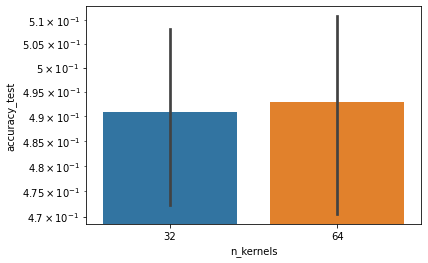

In [64]:
g = sns.barplot(x = 'n_kernels', y = 'accuracy_test', data = df, log=True)
g.set_yticks([0.47, 0.5])

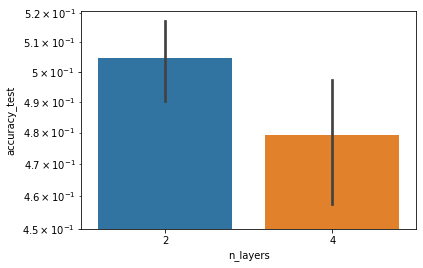

In [66]:
g = sns.barplot(x = 'n_layers', y = 'accuracy_test', data = df, log=True)
g.set_yticks([0.45, 0.5])

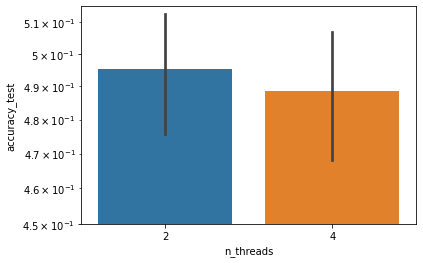

In [67]:
g = sns.barplot(x = 'n_threads', y = 'accuracy_test', data = df, log=True)
g.set_yticks([0.45, 0.5])

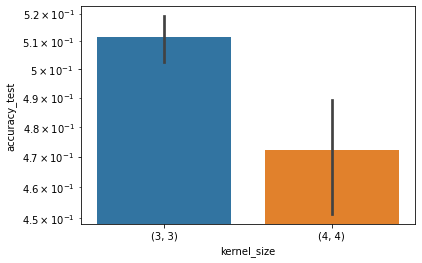

In [68]:
g = sns.barplot(x = 'kernel_size', y = 'accuracy_test', data = df, log=True)
g.set_yticks([0.47, 0.5])

### Выводы по подбору параметров
Видим, что значимую результативность для выбранной конфигурации сети дает использование фильтра меньшего размера (3, 3) и использование меньшего числа слоев: 2 вместо 4.

Незначительный прирост результативности дает использование большего числа ядер (при большем разбросе результата) и меньшее число нитей.

Таким образом, наилучшие результаты получаются для конфигураций:
- Число ядер: 32 или 64.
- Число слоев: 2.
- Число нитей: 2. 
- Размер фильтра: (3, 3).

#### Построим сеть с указанными параметрами и попробуем улучшить ее результат за счет более длительного обучения.

In [76]:
first_input = Input(shape=(32,32,3))
merged = Concatenate(axis =-1)([Conv2D(32, 
                                       (3,3),
                                       name='conv2D_'+str(j),
                                       activation='relu', 
                                       padding = 'same')(first_input) for j in range(2)])
merged_pool = MaxPooling2D(pool_size=(2, 2))(merged)
merged_pool_drop = Dropout(0.25)(merged_pool)
merged_flatten = Flatten()(merged_pool_drop)
x1 = Dense(128,
           name='dense_'+str(i),
           activation='relu')(merged_flatten) 
dense_drop = Dropout(0.5)(x1)
dense_output = Dense(10, activation='softmax')(dense_drop)

final_model = Model(inputs=first_input, outputs=dense_output)
ada_grad = keras.optimizers.Adagrad(learning_rate=0.1, epsilon=1e-08, decay=0.0)
final_model.compile(optimizer=ada_grad, loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
final_model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

# запуск обучения модели
final_model.fit(x_train, 
                y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                callbacks=[early_stop],
                workers=-1)

Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_90 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_0 (Conv2D)              (None, 32, 32, 32)   896         ['input_90[0][0]']               
                                                                                                  
 conv2D_1 (Conv2D)              (None, 32, 32, 32)   896         ['input_90[0][0]']               
                                                                                                  
 concatenate_156 (Concatenate)  (None, 32, 32, 64)   0           ['conv2D_0[0][0]',               
                                                                  'conv2D_1[0][0]']        

Получилось немного улучшить качество модели, в результате обучение прекратилось из-за отсутствия снижения loss в течение одной эпохи.

Посмотрим с какими классами модель больше всего ошибалась

In [82]:
from sklearn.metrics import classification_report
y_pred = final_model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     самолет       0.62      0.66      0.64      1000
  автомобиль       0.64      0.83      0.72      1000
       птица       0.50      0.46      0.48      1000
         кот       0.46      0.43      0.44      1000
       олень       0.59      0.46      0.52      1000
      собака       0.55      0.47      0.50      1000
     лягушка       0.75      0.59      0.66      1000
      лошадь       0.70      0.64      0.67      1000
     корабль       0.62      0.82      0.71      1000
    грузовик       0.62      0.69      0.65      1000

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.60      0.61      0.60     10000



Самая низкая точность у класса "кот" и "птица".

Посмотрим глазами на класс "кот".

In [139]:
N = 15
y_pred_class_3 = np.where(y_pred_class == 3)[0][:N]
y_pred_class_3

array([  0,   8,  17,  33,  53,  59,  77,  83, 103, 127, 128, 142, 149,
       158, 162], dtype=int64)

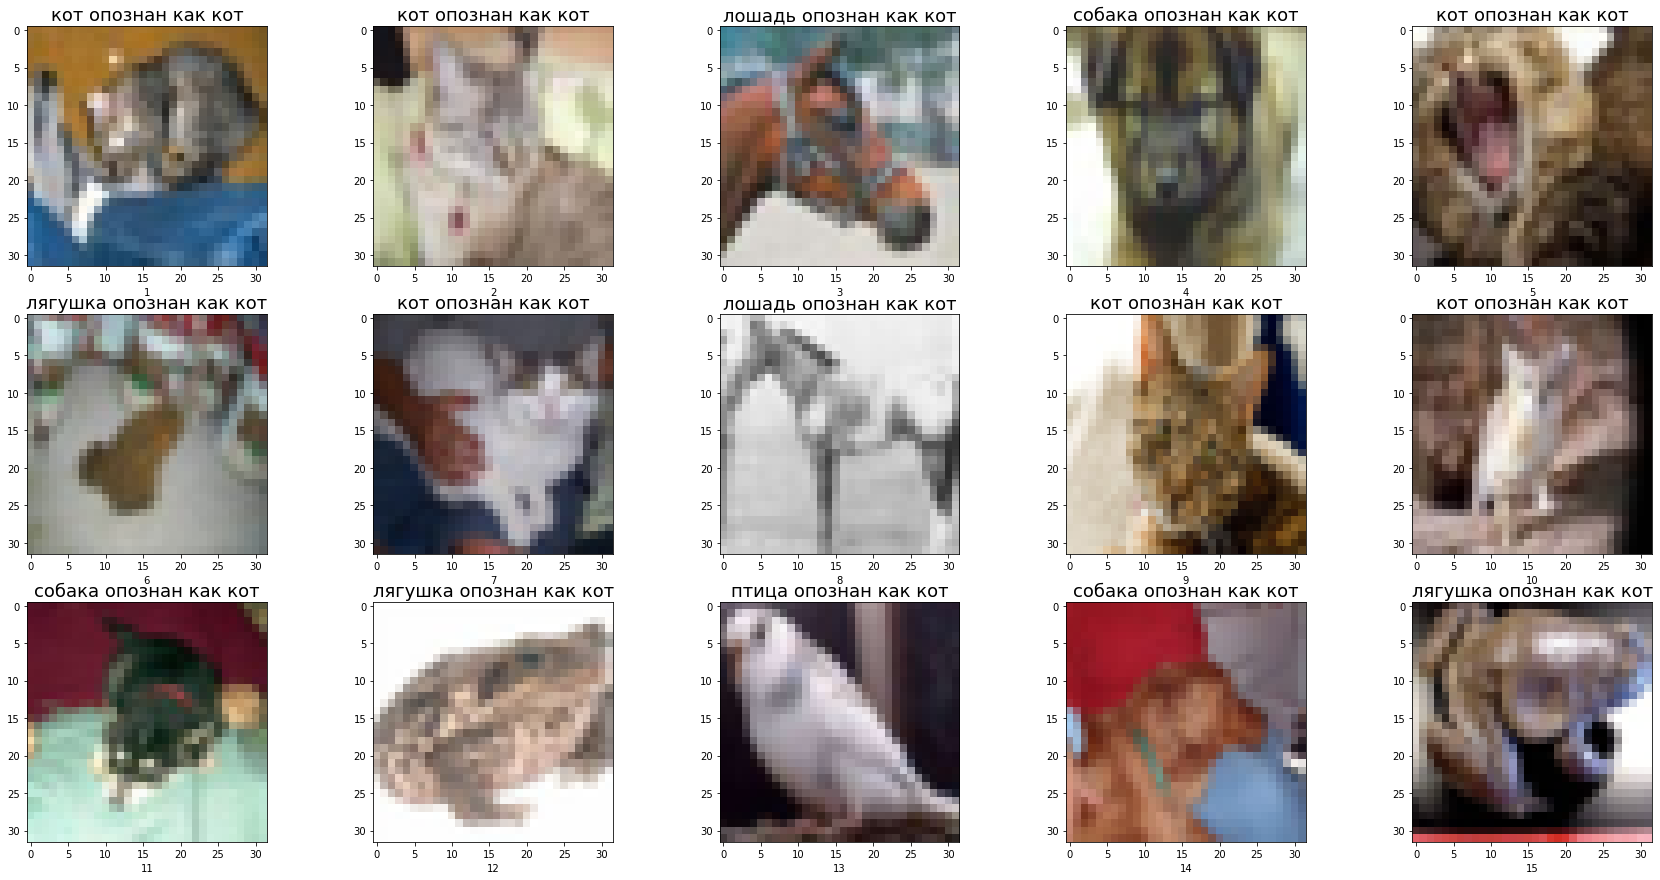

In [148]:
plt.figure(figsize =(2*N,15))
for idx, i in enumerate(y_pred_class_3):
    plt.subplot(3,5,idx+1)
    plt.imshow(x_test[i][:,:,:])
    y_t = np.argmax(y_test[i])
    plt.xlabel(idx + 1)
    plt.title(f'{classes[y_t]} опознан как кот', fontsize=18)
plt.show()  

Кот перепутан моделью со всеми подряд животными.